# Task 11.1. Image indexation
---
***Author: Piotr Skalski***

## 1. Imports

In [1]:
import numpy as np
import cv2
import os
import pprint
from tqdm import tqdm

import display_util

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 2. Primary settings

In [2]:
SOURCE_DIR = "./../data/"
IMAGE_NAME = "ccl1.png"

## 3. Loading images

In [3]:
# building path to file
image_path = os.path.join(SOURCE_DIR, IMAGE_NAME)
# loading files
image = cv2.imread(image_path, 0)

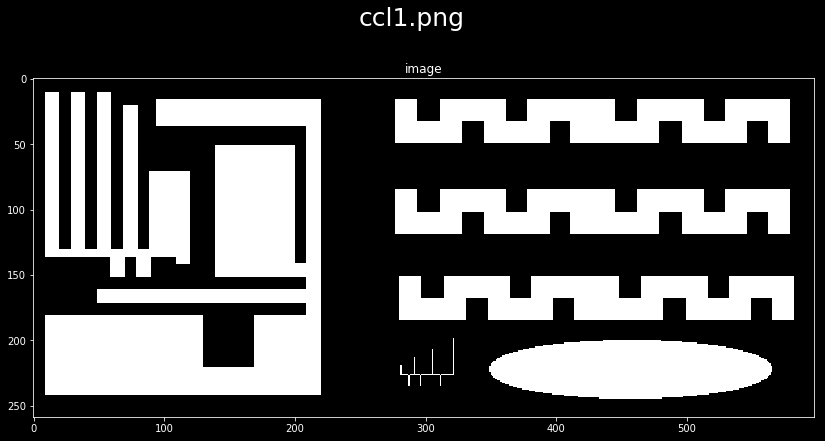

In [4]:
display_util.image(image, IMAGE_NAME, size=(14,7))

## 4. Basic indexation implementation

In [5]:
def get_neighborhood(point):
    return [
        (point[0] - 1, point[1] - 1),
        (point[0] - 1, point[1]),
        (point[0] - 1, point[1] + 1),
        (point[0], point[1] - 1)
    ]

In [6]:
def get_min_and_max_of_list(numbers_list):
    numbers_array = np.array(numbers_list)
    numbers_array = np.ma.masked_equal(numbers_array, 0.0, copy=False)
    return numbers_array.min(), numbers_array.max()

In [7]:
def indexation(input_image):
    image = np.copy(input_image)
    image_height, image_width = image.shape
    current_label = 1
    for row_index in range(1, image_height - 1):
        for column_index in range(1, image_width - 1):
            if image[row_index, column_index] != 0:
                neighbors_indexes = get_neighborhood((row_index, column_index))
                neighbors_values = [image[neighbor_point_index] for neighbor_point_index in neighbors_indexes]
                
                if sum(neighbors_values) == 0:
                    image[row_index, column_index] = current_label
                    current_label += 1
                else:
                    label_min, label_max = get_min_and_max_of_list(neighbors_values)
                    if (label_min == label_max):
                        image[row_index, column_index] = label_min
                    else:
                        image[row_index, column_index] = label_min
            
    
    print("current_label: " + str(current_label))
    return(image)

In [8]:
image_out = indexation(image)

current_label: 49


## 5. Results analysis

### 5.1 Obtained results

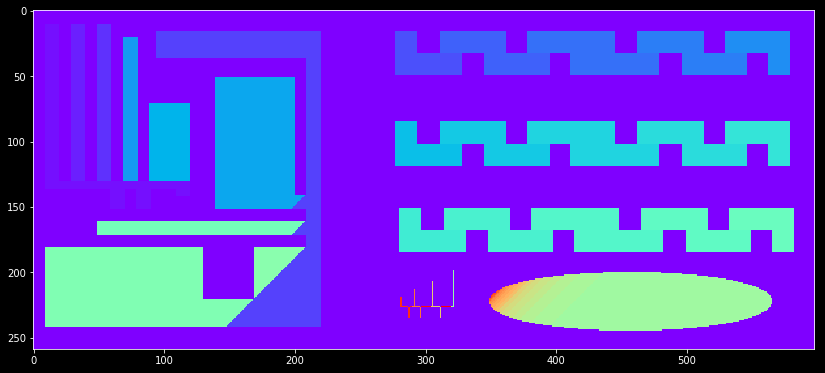

In [9]:
fig = plt.figure(figsize=(14, 7))
plt.imshow(image_out, 'rainbow')

### 5.2. Expected results

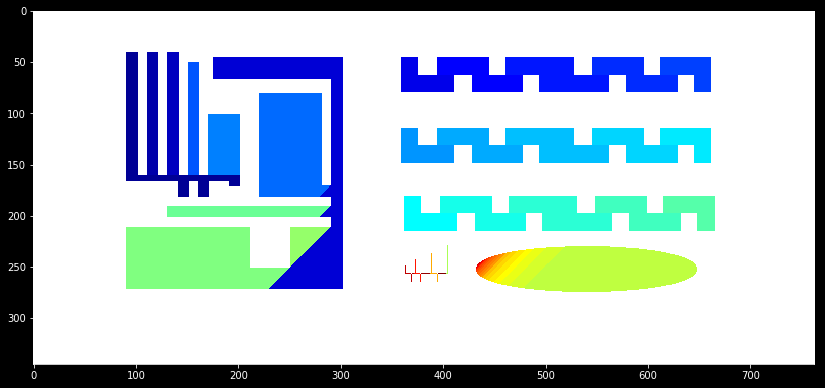

In [10]:
SOURCE_DIR = "./../data/"
IMAGE_NAME = "ccl1Result.png"
image_path = os.path.join(SOURCE_DIR, IMAGE_NAME)
fig = plt.figure(figsize=(14, 7))
plt.imshow(mpimg.imread(image_path))

## 6. Indexation with union implementation

In [11]:
def root(index, union_table):
    current_root = index
    while union_table[current_root] != current_root:
        current_root = union_table[current_root]
    return current_root

In [12]:
def get_lut(union_table):
    lut = union_table[:]
    for i in range(len(lut)):
        lut[i] = root(i, union_table)
    return lut

In [15]:
def indexation_with_union(input_image):
    image = np.copy(input_image)
    image_height, image_width = image.shape
    union_table = list(range(100))
    current_label = 1
    
    # FIRST PASS
    
    for row_index in range(1, image_height - 1):
        for column_index in range(1, image_width - 1):
            if image[row_index, column_index] != 0:
                neighbors_indexes = get_neighborhood((row_index, column_index))
                neighbors_values = [image[neighbor_point_index] for neighbor_point_index in neighbors_indexes]
                
                if sum(neighbors_values) == 0:
                    image[row_index, column_index] = current_label
                    current_label += 1
                else:
                    label_min, label_max = get_min_and_max_of_list(neighbors_values)
                    if (label_min == label_max):
                        image[row_index, column_index] = label_min
                    else:
                        image[row_index, column_index] = label_min
                        union_table[label_min] = label_max
            
    lut = get_lut(union_table)
    
    # SECOND PASS
    
    for row_index in range(1, image_height - 1):
        for column_index in range(1, image_width - 1):
            if image[row_index, column_index] != 0:
                image[row_index, column_index] = lut[image[row_index, column_index]]
    
    print("current_label: " + str(current_label))
    return(image)

In [16]:
image_out_union = indexation_with_union(image)

current_label: 49


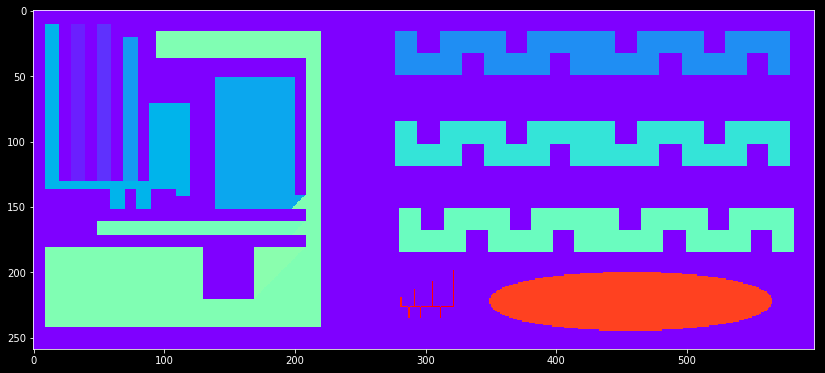

In [17]:
fig = plt.figure(figsize=(14, 7))
plt.imshow(image_out_union, 'rainbow')

## 7. My idea for indexation implementation

In [62]:
def update_union_table(min_label, max_label, union_table):
    union_table_out = []
    sets_to_marge = []
    for union_set in union_table:
        if min_label in union_set or max_label in union_set:
            union_set.add(min_label)
            union_set.add(max_label)
            sets_to_marge.append(union_set)
        else:
            union_table_out.append(union_set)
            
    if len(sets_to_marge) == 0:
        return union_table_out
    if len (sets_to_marge) == 1:
        union_table_out.append(sets_to_marge[0])
        return union_table_out
    else:
        last_set = sets_to_marge[0]
        for i in range(1, len(sets_to_marge)):
            last_set = last_set.union(sets_to_marge[i])
        union_table_out.append(last_set)
        return union_table_out

In [63]:
def get_lut_from_set(union_table):
    lut = list(range(100))
    for set_index, union_set in enumerate(union_table):
        print(union_set)
        union_list = list(union_set)
        for element in union_list:
            lut[element] = set_index + 1
    return lut

In [64]:
def indexation_with_sets(input_image):
    image = np.copy(input_image)
    image_height, image_width = image.shape
    union_table = []
    current_label = 1
    
    # FIRST PASS
    
    for row_index in range(1, image_height - 1):
        for column_index in range(1, image_width - 1):
            if image[row_index, column_index] != 0:
                neighbors_indexes = get_neighborhood((row_index, column_index))
                neighbors_values = [image[neighbor_point_index] for neighbor_point_index in neighbors_indexes]
                
                if sum(neighbors_values) == 0:
                    image[row_index, column_index] = current_label
                    union_table.append(set([current_label]))
                    current_label += 1
                else:
                    label_min, label_max = get_min_and_max_of_list(neighbors_values)
                    if (label_min == label_max):
                        image[row_index, column_index] = label_min
                    else:
                        image[row_index, column_index] = label_min
                        union_table = update_union_table(label_min, label_max, union_table)
            
    lut = get_lut_from_set(union_table)
    
    # SECOND PASS
    
    for row_index in range(1, image_height - 1):
        for column_index in range(1, image_width - 1):
            if image[row_index, column_index] != 0:
                image[row_index, column_index] = lut[image[row_index, column_index]]
    
    print("current_label: " + str(current_label))
    return(image)

In [65]:
image_out_set = indexation_with_sets(image)

{5, 6, 7, 8, 9}
{16, 17, 13, 14, 15}
{1, 2, 3, 10, 12}
{18, 19, 20, 21, 22}
{34, 41, 45, 46, 47, 48, 26}
{27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 42, 43, 44}
{4, 23, 24, 25, 11}
current_label: 49


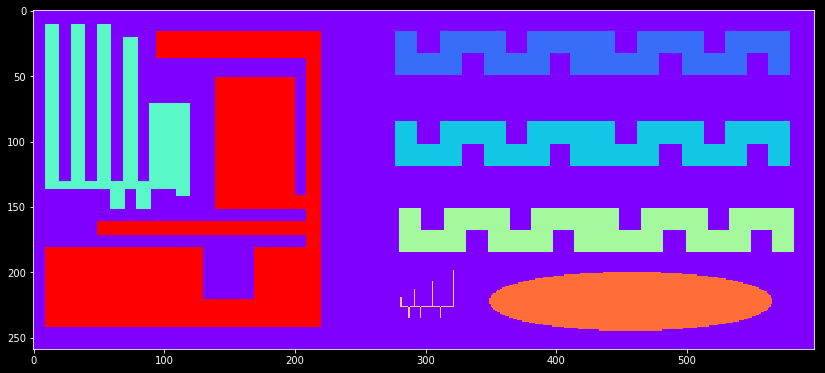

In [66]:
fig = plt.figure(figsize=(14, 7))
plt.imshow(image_out_set, 'rainbow')